# Exercise 4: Convolutional Neural Networks


## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.


In [56]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import logger

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torchvision.datasets as data_set



---
## Task 3: Convolutional Neural Networks

Now we want to move on to train our classifier on CIFAR10 with PyTorch.

### Task 3.1: Dataset

Files already downloaded and verified


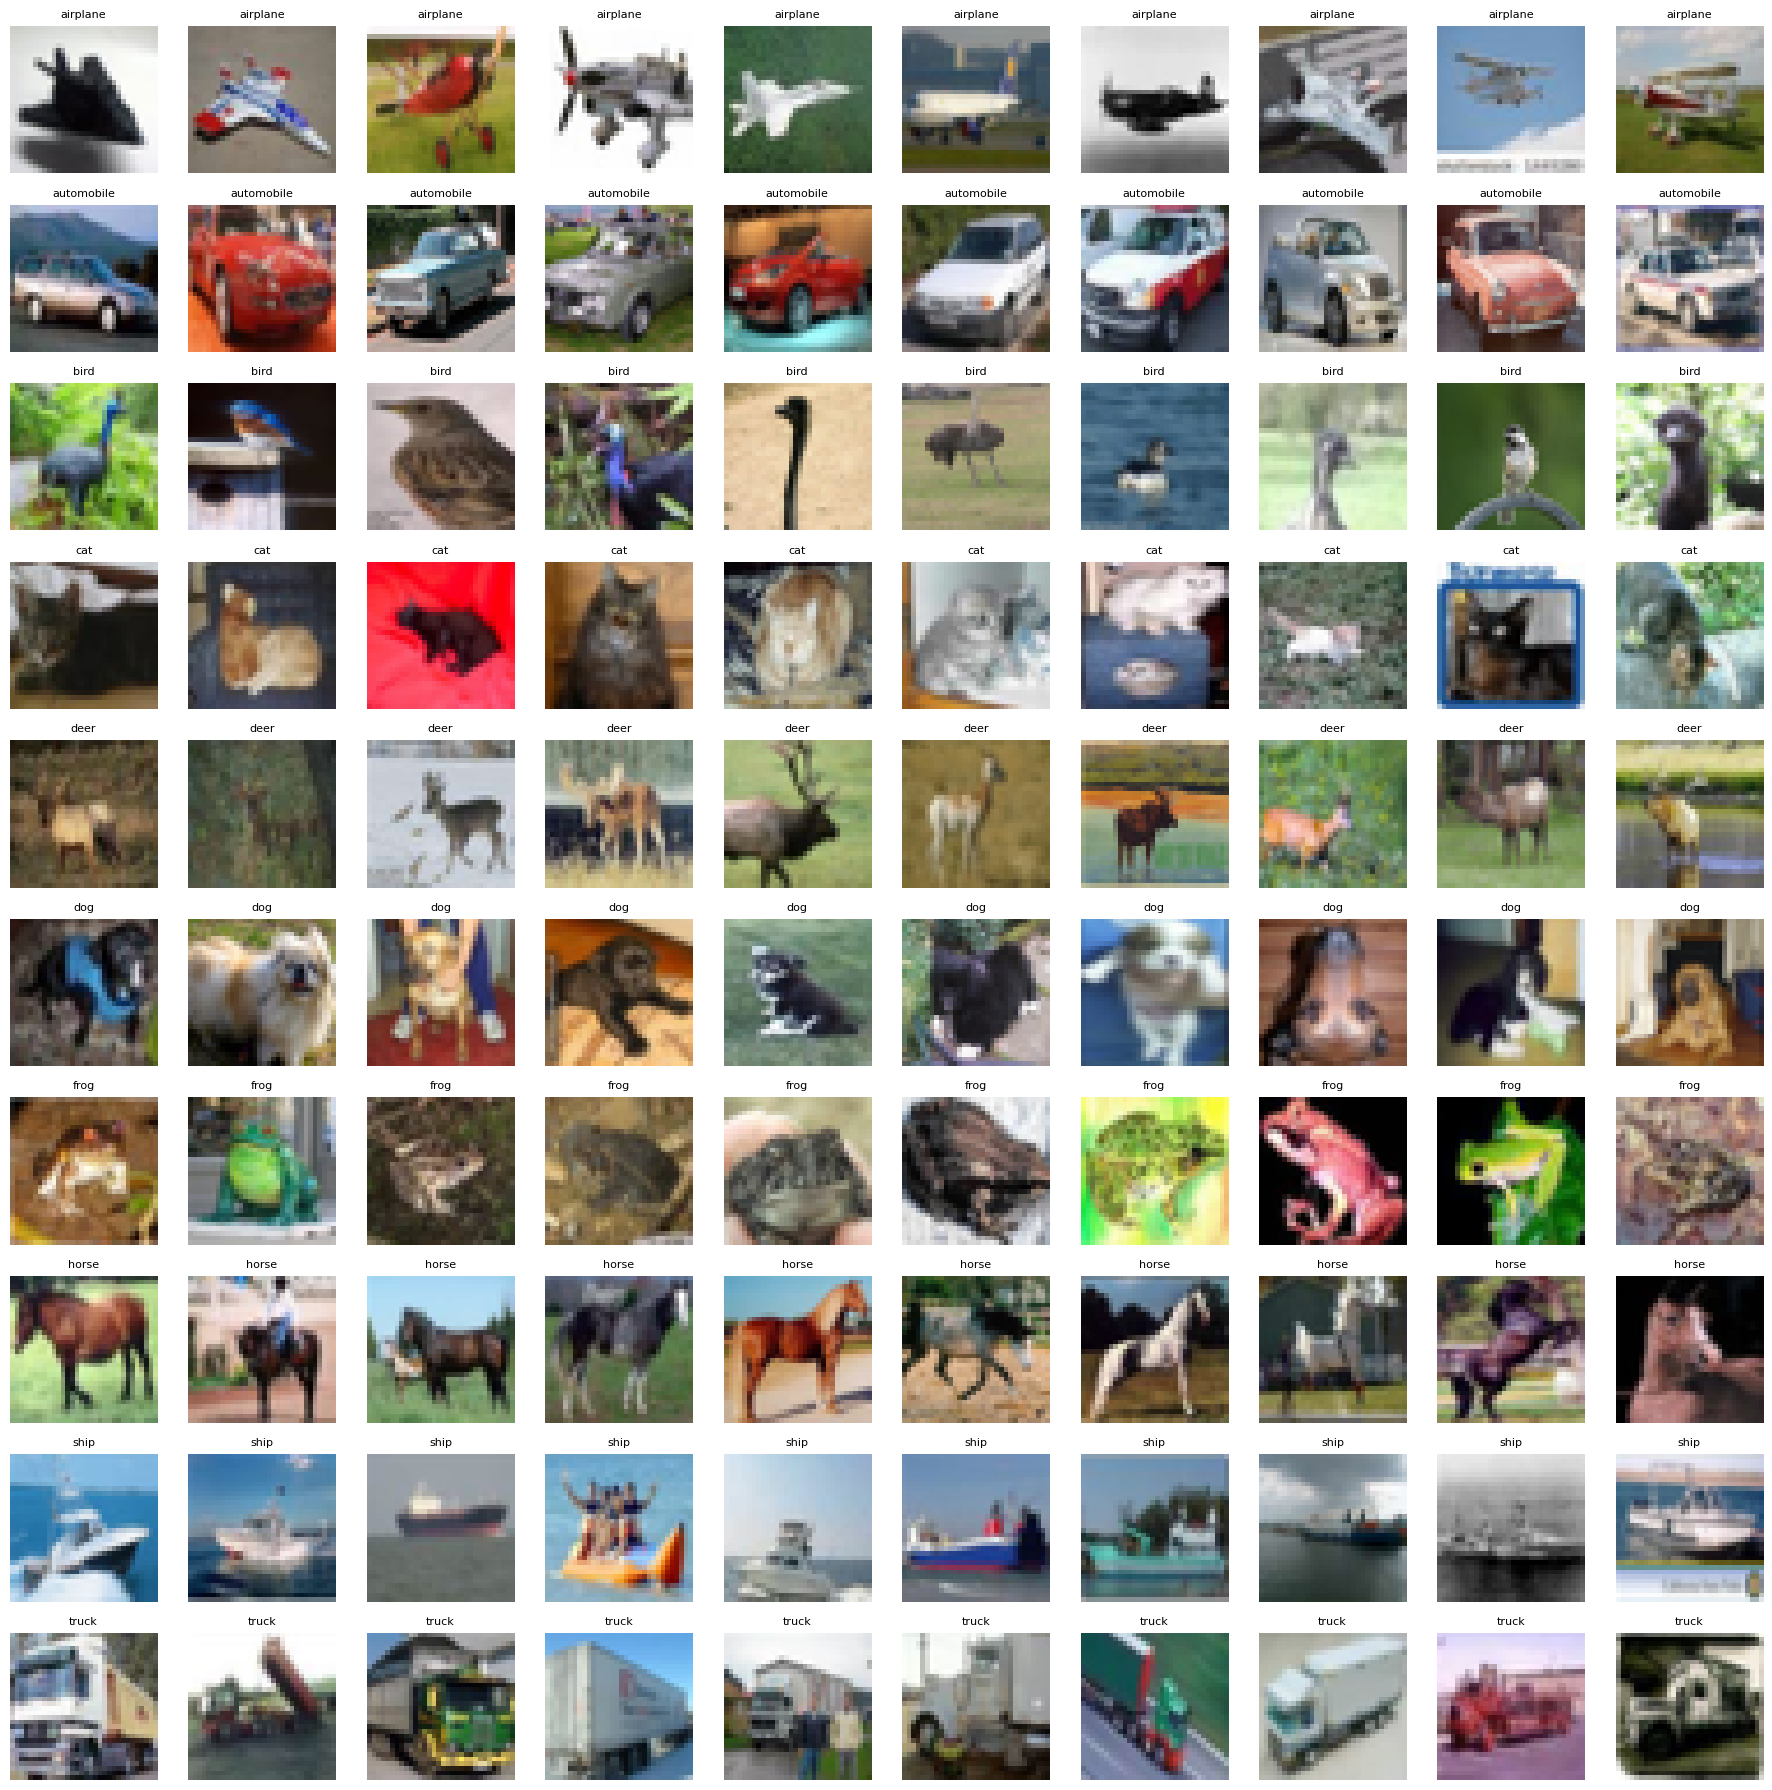

In [57]:
transform = T.ToTensor() # allready soncerting images from [0,255] to [0,1] 
dataset: data_set.CIFAR10 = data_set.CIFAR10(root='./data', train=True, download=True, transform=transform)

classes = dataset.classes 

images_per_class = {label: [] for label in range(10)}
for img, label in dataset:
    if len(images_per_class[label]) < 10:
        images_per_class[label].append(img)
    if all(len(imgs) == 10 for imgs in images_per_class.values()):
        break

fig, axes = plt.subplots(10, 10, figsize=(18, 18))
for class_idx in range(10):
    for i in range(10):
        img = images_per_class[class_idx][i].permute(1, 2, 0).numpy()
        ax = axes[class_idx][i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(classes[class_idx], fontsize=8)
        
plt.tight_layout()
plt.show()
    


### 3.2 Network

In [58]:
class Net(nn.Module):
    def __init__(self):
        ############ your code here ############
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
        ############ end of your code############
    
    def forward(self, x):
        ############ your code here ############
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        ############ end of your code############
        return x

my_NET = Net()
print(my_NET)

num_params = sum(p.numel() for p in my_NET.parameters() if p.requires_grad) # Count all trainable parameters (those with requires_grad=True) across the network
print(f"Total trainable parameters: {num_params}")

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
Total trainable parameters: 62006


### 3.3 Training

In [59]:
# ensuring to run the training on cpu and not cuda (macbook owner :))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_NET.to(device)

# automatic batching and shuffling
train_data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_NET.parameters(), lr=0.001)

train_accuracies = []
test_accuracies = []

# split train, val
test_dataset = data_set.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# training loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    accuracy = 100 * running_correct / total
    return accuracy

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        _, pred = torch.max(output, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        
    accuracy = 100 * correct / total
    return accuracy

Files already downloaded and verified


Plot how the accuracy (i.e. percentage of correctly classified images) of your model evolves for both, the training- and test-set of CIFAR10. Please make sure to add meaningful axis labels for your plot (y-axis as
the accuracy and x-axis as the epoch number).

In [52]:
#training without augmentation :
for epoch in range(10):
    train_acc = train_one_epoch(my_NET, train_data_loader, criterion,optimizer, device)
    test_acc = evaluate(my_NET, test_loader, device)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    logger.logger.info(f"Epoch: {epoch:2d} - Train Accuracy: {train_acc:2f}%, Test Accuracy: {test_acc:2f}%")

[05/Jun/2025 16:24:10] INFO - Epoch:  0 - Train Accuracy: 38.920000%, Test Accuracy: 47.920000%
[05/Jun/2025 16:24:34] INFO - Epoch:  1 - Train Accuracy: 50.760000%, Test Accuracy: 52.520000%
[05/Jun/2025 16:24:57] INFO - Epoch:  2 - Train Accuracy: 55.074000%, Test Accuracy: 54.850000%
[05/Jun/2025 16:25:20] INFO - Epoch:  3 - Train Accuracy: 57.948000%, Test Accuracy: 56.420000%
[05/Jun/2025 16:25:43] INFO - Epoch:  4 - Train Accuracy: 60.268000%, Test Accuracy: 57.270000%
[05/Jun/2025 16:26:05] INFO - Epoch:  5 - Train Accuracy: 62.102000%, Test Accuracy: 59.250000%
[05/Jun/2025 16:26:29] INFO - Epoch:  6 - Train Accuracy: 63.648000%, Test Accuracy: 59.450000%
[05/Jun/2025 16:26:52] INFO - Epoch:  7 - Train Accuracy: 64.616000%, Test Accuracy: 60.470000%
[05/Jun/2025 16:27:14] INFO - Epoch:  8 - Train Accuracy: 65.822000%, Test Accuracy: 60.750000%
[05/Jun/2025 16:27:37] INFO - Epoch:  9 - Train Accuracy: 66.732000%, Test Accuracy: 61.020000%


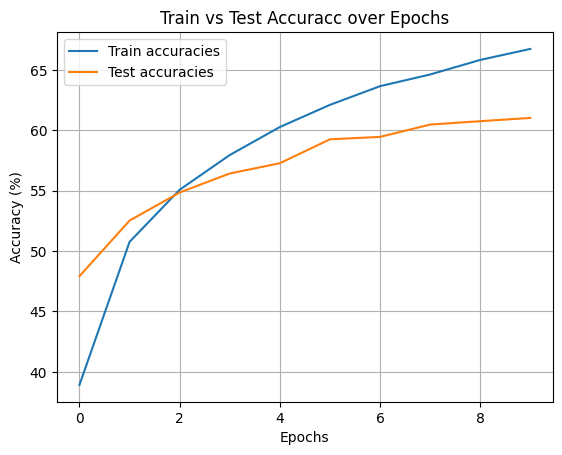

In [53]:

plt.plot(train_accuracies, label="Train accuracies")
plt.plot(test_accuracies, label="Test accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracc over Epochs")
plt.legend()
plt.grid("True")
plt.show()

What do you observe in the accuracy plot, in particular if you compare the train and test accuracy? Do you have an explanation for that?

- Training accuracy increases steadily across epochs.
- Test accuracy improves moderately but lags behind training accuracy.
- A visible gap between train and test accuracy indicates mild overfitting.
- Despite the gap, the model still generalizes reasonably well to unseen data.


### 3.4 Augmentation

In [60]:
transform_augment = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    # normalize (mean and standard derivation for the first 3)
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

Train your model using the same setup as above, however, with additional normalization (normalize your input images channel-wise using μ = 0.5 and σ = 0.5) and data augmentation.

In [61]:
# training with Augmentation
augmented_model = Net().to(device) 

augmented_train_dataset = data_set.CIFAR10(root="./data", train=True, download=True, transform=transform_augment)# now with augmentation
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(augmented_model.parameters(), lr=0.001)

aug_train_accs = []
aug_test_accs = []

for epoch in range(10):
    train_acc = train_one_epoch(augmented_model, augmented_train_loader, criterion, optimizer_aug, device)
    test_acc = evaluate(augmented_model, test_loader, device)

    aug_train_accs.append(train_acc)
    aug_test_accs.append(test_acc)

    logger.logger.info(f"[AUG] Epoch {epoch+1} — Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Files already downloaded and verified
[05/Jun/2025 16:34:25] INFO - [AUG] Epoch 1 — Train Acc: 35.94%, Test Acc: 26.64%
[05/Jun/2025 16:35:16] INFO - [AUG] Epoch 2 — Train Acc: 44.76%, Test Acc: 25.72%
[05/Jun/2025 16:36:09] INFO - [AUG] Epoch 3 — Train Acc: 47.98%, Test Acc: 28.86%
[05/Jun/2025 16:37:03] INFO - [AUG] Epoch 4 — Train Acc: 50.48%, Test Acc: 30.54%
[05/Jun/2025 16:37:56] INFO - [AUG] Epoch 5 — Train Acc: 51.73%, Test Acc: 29.33%
[05/Jun/2025 16:38:48] INFO - [AUG] Epoch 6 — Train Acc: 52.11%, Test Acc: 31.50%
[05/Jun/2025 16:39:38] INFO - [AUG] Epoch 7 — Train Acc: 53.20%, Test Acc: 31.22%
[05/Jun/2025 16:40:30] INFO - [AUG] Epoch 8 — Train Acc: 54.42%, Test Acc: 33.68%
[05/Jun/2025 16:41:22] INFO - [AUG] Epoch 9 — Train Acc: 54.58%, Test Acc: 26.19%
[05/Jun/2025 16:42:16] INFO - [AUG] Epoch 10 — Train Acc: 55.42%, Test Acc: 27.96%


Plot the accuracy of this model and the one you trained before over time. Make sure to use proper axis labels and a meaningful legend.

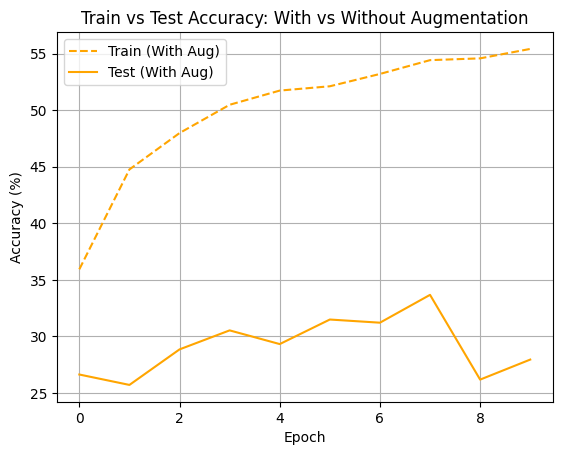

In [65]:
import matplotlib.pyplot as plt
plt.plot(aug_train_accs, label="Train (With Aug)", linestyle='--', color='orange')
plt.plot(aug_test_accs, label="Test (With Aug)", linestyle='-', color='orange')

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy: With vs Without Augmentation")
plt.legend()
plt.grid(True)
plt.show()


Based on your results, provide a brief discussion of why the extra normalization and augmentation improves/harms the performance of your model.

- Without augmentation: test accuracy improves steadily, showing moderate generalization.
- With augmentation: test accuracy remains low and unstable despite rising training accuracy.
- Likely issues:
  - Augmentations (e.g., `ColorJitter`, `RandomRotation`) may be too strong.
  - Increased input variability makes learning harder with limited epochs.
  - Possible over-regularization or distortion of important features.
- Conclusion: Augmentation can help generalization, but if too aggressive, it may harm performance.


---
## Task 4: Activation and Saliency Maps

In this task, we will try to visualize what CNNs learn by means of the activation
map, which is considered to be more informative than just visualizing e.g. the
kernel weights.

### 4.1 Instantiate a pre-traind ResNet18

In [66]:
from torchvision.models import resnet18

############ your code here ############
# Instantiate your model ResNet18
# turn the model into evaluation mode
# and print out the architecture 

# TODO
model = resnet18(weights=False).to(device)
model.eval()
print(model)

############ end of your code############

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Intermediate Activation Maps

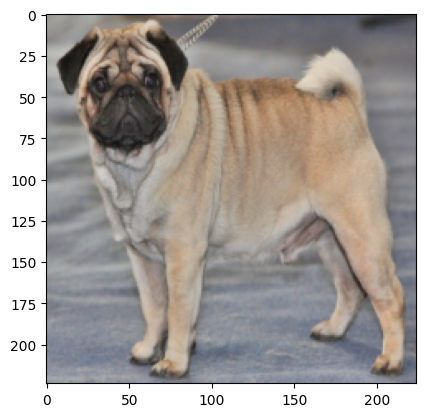

In [68]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the provided image and get the output
image = Image.open('pug.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

def show_tensor(tensor):
    if tensor.ndim == 4:
        temp = tensor.squeeze()
    else: temp=tensor
    plt.imshow(temp.cpu().permute(1,2,0))

show_tensor(X.squeeze())


Store intermediate activation maps..


In [72]:
############ your code here ############
activations_map = {}
def get_activation(name):
    def hook(model, input, output):
        activations_map[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.layer2[0].conv1.register_forward_hook(get_activation('conv3')) 

output = model(X)

print("conv1 output shape:", activations_map['conv1'].shape)
print("conv3 output shape:", activations_map['conv3'].shape)


############ end of your code############

conv1 output shape: torch.Size([1, 64, 112, 112])
conv3 output shape: torch.Size([1, 128, 28, 28])


### 4.3 Visualize the Activation Maps

In [73]:
############ your code here ############
def visualize_activations(activation_tensor, layer_name, num_channels=6):
    """
    Visualize the first `num_channels` feature maps from a layer.
    """
    act = activation_tensor.squeeze(0).cpu()  # Remove batch dimension

    plt.figure(figsize=(15, 5))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(act[i], cmap='viridis')  
        plt.axis('off')
        plt.title(f"{layer_name} - ch {i}")
    plt.tight_layout()
    plt.show()

############ end of your code############

### 4.4 Plot Image and Activation Map

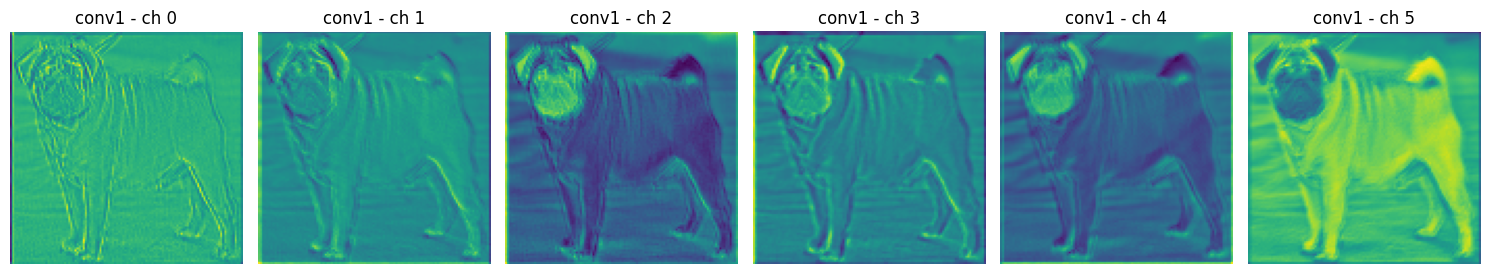

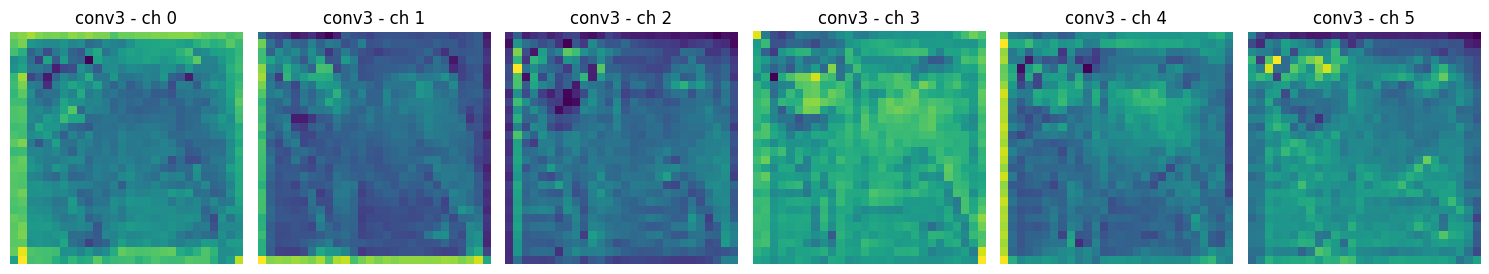

In [74]:
############ your code here ############
# visualize one of the activation maps on top of the original image
# you may need image resampling for this and the imshow(...,alpha=)
visualize_activations(activations_map['conv1'], 'conv1', num_channels=6)

visualize_activations(activations_map['conv3'], 'conv3', num_channels=6)

############ end of your code############

### 4.5 Saliency Map
Introduced in: *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*

In [84]:
# illustrate how gather() works
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

# load the images
names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

X = [np.array(Image.open(name).convert('RGB')) for name in names]
y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]

# intentionally change the label to a wrong one
y[1] = 285

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
    ])
    return transform(img)

tensor([[ 1.1354,  0.5670, -1.0278, -0.7606, -0.5448],
        [-0.5798, -1.5157,  0.3472,  0.8977, -0.5803],
        [ 0.2197,  0.8838, -0.5889, -1.4517,  0.8750],
        [ 2.2812, -0.2996, -1.6353,  0.5649, -0.5609]])
tensor([1, 2, 1, 3])
tensor([0.5670, 0.3472, 0.8838, 0.5649])


#### a) Complete the saliency map function.

In [80]:
def saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = X.clone().detach().to(device)
    X_var.requires_grad = True
    y = y.to(device)

    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    scores = model(X_var) 
    # "gather" extracts the score corresponding to the ground-truth class for each image.
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze() 
    correct_scores.backward(torch.ones_like(correct_scores))
    saliency = X_var.grad.data.abs().max(dim=1)[0] 
    

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

#### b) Visualize the original images together with the saliency maps.

Visualize the original image with the saliency maps together and provide a short discussion on why different ground truth labels with even the same input image would yield different saliency maps, for instance, the catdog_243.png image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).

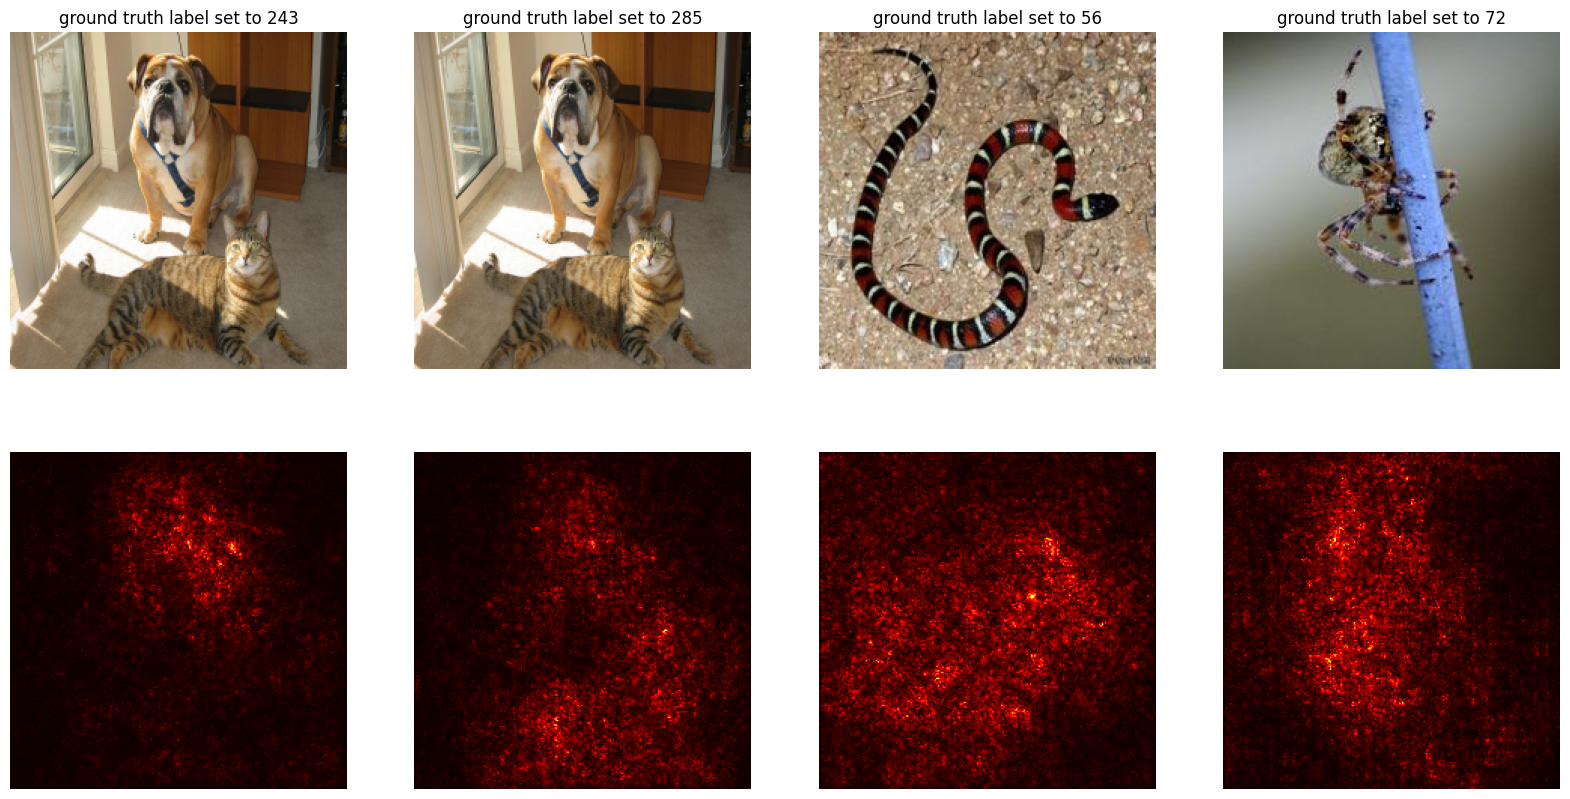

In [85]:
# Please use the same pre-trained network from the previous task for this task
model = resnet18(weights=True).to(device)
model.eval()

# if you finished the task 3.1 and defined your model, then this function should run flawlessly
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency = saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title('ground truth label set to {}'.format(y[i]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()


show_saliency_maps(X, y)

---

In [86]:
import numpy as np
from pprint import pprint

# Input image
x = np.array([
    [1, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 1],
    [0, 0, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1]
])

# Kernels
w1 = np.array([[1, 0], [0, 1]])
w2 = np.array([[1, 0], [1, 0]])
w3 = np.array([[1, 1], [0, 0]])
kernels = [w1, w2, w3]
bias = -1

def apply_conv_relu(x, kernel, bias, stride=1):
    kH, kW = kernel.shape
    H, W = x.shape

    out_H = (H - kH) // stride + 1
    out_W = (W - kW) // stride + 1

    out = np.zeros((out_H, out_W))
    for i in range(out_H):
        for j in range(out_W):
            patch = x[i*stride:i*stride+kH, j*stride:j*stride+kW]
            out[i, j] = np.sum(patch * kernel) + bias

    return np.maximum(0, out)

# Apply each kernel with stride (you can change stride here)
stride = 1
outputs = []
for kernel in kernels:
    result = apply_conv_relu(x, kernel, bias, stride)
    outputs.append(result)

# Stack into a 3D tensor
tensor_output = np.stack(outputs, axis=0)

# Print
print("Final output tensor shape:", tensor_output.shape)
pprint(tensor_output)


Final output tensor shape: (3, 4, 5)
array([[[1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.]]])
